In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# =====================================================
# ランダムウォーク系列（Random Walk）の生成
# =====================================================

# 乱数の種を固定（再現性のため）
np.random.seed(1)

# 正規分布 N(0,1) に従う乱数を100個生成
# loc=平均0, scale=標準偏差1, size=サンプル数
sim_size = 100

# 乱数を累積和してランダムウォーク系列を作成
# ランダムウォークとは：前時点の値にランダムな変化量（誤差）を加えて進む過程
rw = np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size))

In [4]:
# =====================================================
# 季節ランダムウォーク（Seasonal Random Walk）の生成
# =====================================================

# 乱数の種を固定（再現性の確保）
np.random.seed(1)

# シミュレーションの長さ（観測数）
srw = np.zeros(sim_size)

# 最初の4時点（初期値）に正規乱数を代入
# loc=平均0, scale=標準偏差1 の正規分布に従う乱数
np.put(srw, [0, 1, 2, 3], stats.norm.rvs(loc=0, scale=1, size=4))

# 5時点目以降のデータを生成
# 4期前の値にノイズを加えて生成することで、「周期4のランダムウォーク」となる
for i in range(4, sim_size):
    np.put(srw, i, srw[i - 4] + stats.norm.rvs(loc=0, scale=1, size=1))

array([<Axes: >, <Axes: >], dtype=object)

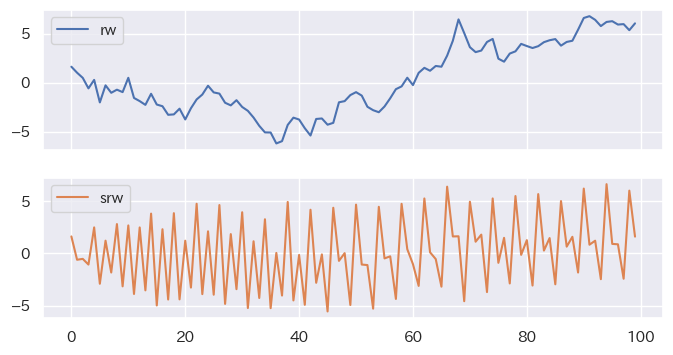

In [5]:
# DataFrameにまとめる
rw_df = pd.DataFrame({"rw": rw, "srw": srw})

# 可視化
rw_df.plot(subplots=True)

array([<Axes: >, <Axes: >], dtype=object)

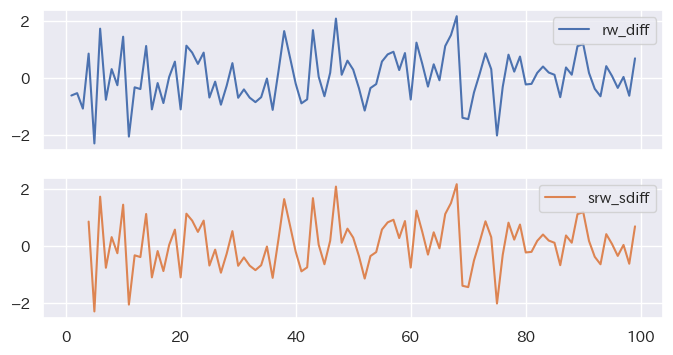

In [6]:
# =====================================================
# ランダムウォークと季節ランダムウォークの差分系列の比較
# =====================================================

# ランダムウォーク過程の1階差分系列を作成
# 差分をとることで、非定常なランダムウォークが「白色ノイズ系列」に近づく
rw_df["rw_diff"] = rw_df.diff(1).rw

# 季節ランダムウォーク過程の季節差分系列を作成
# 4期前との差分（季節差分）を取ることで、季節的ランダムウォークが定常化する
rw_df["srw_sdiff"] = rw_df.diff(4).srw

# =====================================================
# グラフ描画：差分系列の可視化
# =====================================================
rw_df[["rw_diff", "srw_sdiff"]].plot(subplots=True)

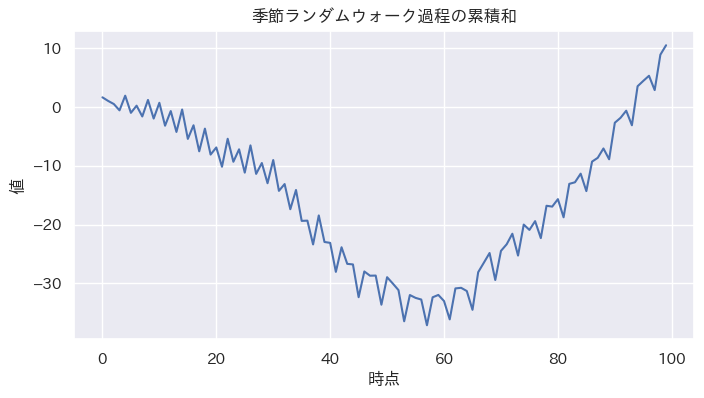

In [7]:
# =====================================================
# 季節ランダムウォーク過程の累積和の可視化
# =====================================================

# 季節ランダムウォーク系列（srw）に対して、さらに累積和をとる
# → ランダムウォークの「2重累積和」に相当し、
#    非定常性がさらに強くなる（トレンドがより顕著になる）
strw = rw_df["srw"].cumsum()

# グラフ描画
plt.plot(strw)
plt.title("季節ランダムウォーク過程の累積和")
plt.xlabel("時点")
plt.ylabel("値")
plt.grid(True)

In [8]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成
air_passengers.index = pd.date_range(
    start="1949-01-01", periods=len(air_passengers), freq="MS"
)

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# 訓練データとテストデータに分割する
train = air_passengers.loc["1949-01":"1957-12"]
test = air_passengers.loc["1958-01":"1960-12"]

In [9]:
# =====================================================
# SARIMA（季節自己回帰和分移動平均）モデルの学習
# =====================================================

# SARIMA(p=3, d=1, q=2)(P=1, D=1, Q=1, s=12)
# → 非季節成分：(3, 1, 2)
# → 季節成分　：(1, 1, 1, 12)
#    s=12 は「12ヶ月周期（年単位の季節性）」を表す。
mod_sarima = tsa.SARIMAX(
    train,  # 学習データ（時系列）
    order=(3, 1, 2),  # 非季節ARIMA(p, d, q)
    seasonal_order=(1, 1, 1, 12),  # 季節成分(P, D, Q, s)
).fit(
    maxiter=1000
)  # 収束しない場合に備えて反復回数を増やす

# 推定されたパラメータを表示
print(mod_sarima.params)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21511D+00    |proj g|=  4.54162D-02

At iterate    5    f=  3.21332D+00    |proj g|=  1.24293D-02

At iterate   10    f=  3.20996D+00    |proj g|=  5.43837D-03

At iterate   15    f=  3.20815D+00    |proj g|=  2.23577D-02

At iterate   20    f=  3.20470D+00    |proj g|=  8.72582D-03

At iterate   25    f=  3.20314D+00    |proj g|=  3.73022D-03

At iterate   30    f=  3.20270D+00    |proj g|=  5.15337D-03


 This problem is unconstrained.



At iterate   35    f=  3.20266D+00    |proj g|=  9.70822D-04

At iterate   40    f=  3.20266D+00    |proj g|=  2.70198D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     46      1     0     0   6.305D-06   3.203D+00
  F =   3.2026639265593810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ar.L1        0.490078
ar.L2        0.323662
ar.L3       -0.145456
ma.L1       -0.750350
ma.L2       -0.161104
ar.S.L12    -0.251569
ma.S.L12     0.110753
sigma2      84.290931
dtype: float64


In [10]:
# 参考：
print(mod_sarima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                  108
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -345.888
Date:                              Tue, 14 Oct 2025   AIC                            707.775
Time:                                      19:36:45   BIC                            728.206
Sample:                                  01-01-1949   HQIC                           716.031
                                       - 12-01-1957                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4901      0.712      0.689      0.491      -0.905       1.885
ar.L2          0.32

In [11]:
# =====================================================
# SARIMAモデル（ソフトウェア間で互換性の高い設定）
# =====================================================

# 以下の設定により、RやEViewsなど他の統計ソフトの推定方式と
# 近い結果を得ることができる。
# -----------------------------------------------------
# ・trend='n'：定数項なし（トレンドなし）
# ・simple_differencing=True：単純差分を使用（通常の差分演算）
# ・hamilton_representation=True：Hamilton形式（標準的な状態空間表現）
# ・cov_type='approx'：近似共分散を使用（数値安定性を向上）
# ・method='nm'：Nelder-Mead法（勾配を使わないロバストな最適化）
# ・maxiter=10000：収束までの最大反復回数を増加
# =====================================================

print(
    tsa.SARIMAX(
        train,
        order=(3, 1, 2),  # 非季節成分 (p, d, q)
        seasonal_order=(1, 1, 1, 12),  # 季節成分 (P, D, Q, s)
        trend="n",  # トレンド（定数項）なし
        simple_differencing=True,  # 差分を単純化
        hamilton_representation=True,  # 標準状態空間表現
    )
    .fit(
        cov_type="approx",  # 共分散の近似計算
        maxiter=10000,  # 最大反復回数
        method="nm",  # Nelder-Mead最適化
    )
    .summary()
)

Optimization terminated successfully.
         Current function value: 3.640928
         Iterations: 1267
         Function evaluations: 1819
                                      SARIMAX Results                                       
Dep. Variable:                         D.DS12.value   No. Observations:                   95
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -345.888
Date:                              Tue, 14 Oct 2025   AIC                            707.776
Time:                                      19:37:38   BIC                            728.207
Sample:                                  02-01-1950   HQIC                           716.032
                                       - 12-01-1957                                         
Covariance Type:                             approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

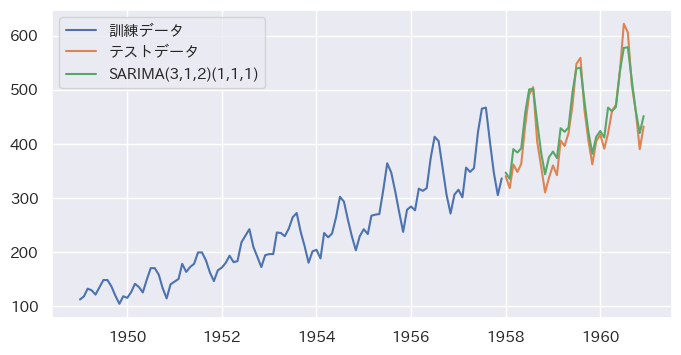

In [12]:
# 予測
pred_sarima = mod_sarima.forecast(36)

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 飛行機乗客数の折れ線グラフ
ax.plot(train["value"], label="訓練データ")
ax.plot(test["value"], label="テストデータ")

# 予測値の折れ線グラフ
ax.plot(pred_sarima, label="SARIMA(3,1,2)(1,1,1)")

# 凡例
ax.legend()

In [15]:
# データの読み込み
ts_sales_bj = pd.read_csv(
    "4-3-1-sales-data.csv",  # ファイル名
    index_col="date",  # インデックスとして扱う列名
    parse_dates=True,  # インデックスを「時間軸」として扱う
    dtype="float",  # データの型(浮動小数点)
)

ts_sales_bj.index.freq = "MS"

# 結果の確認
print(ts_sales_bj.head(3))

            sales  discount
date                       
2010-01-01   71.0       0.0
2010-02-01   67.0       0.0
2010-03-01   64.0       0.0


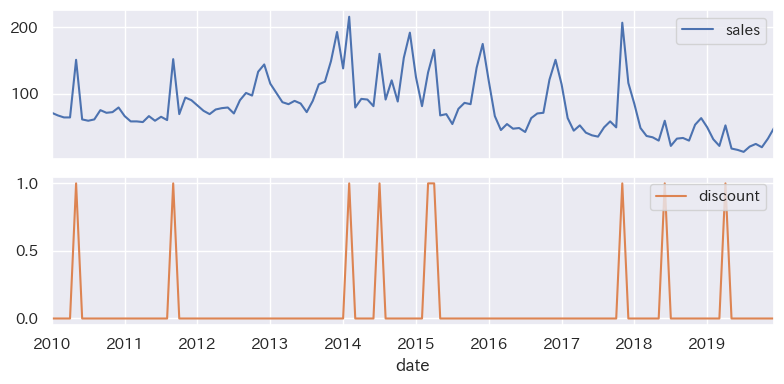

In [16]:
# 可視化
ts_sales_bj.plot(subplots=True)
plt.tight_layout()

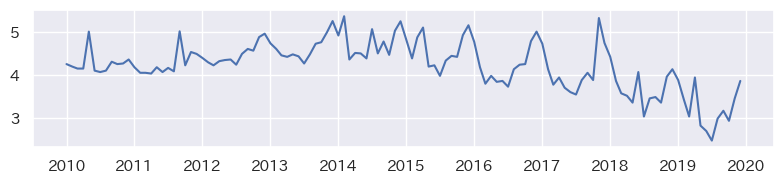

In [17]:
# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# 対数変換したグラフ
ax.plot(np.log(ts_sales_bj["sales"]))

In [18]:
# 訓練データとテストデータに分割する
train = ts_sales_bj.loc["2010-01":"2018-12"]
test = ts_sales_bj.loc["2019-01":"2019-12"]

In [19]:
# =====================================================
# SARIMAX モデル（外生変数付き季節ARIMA）の推定
# =====================================================
# ・目的変数：log(sales)
# ・説明変数（外生変数）：discount（割引率など）
# ・モデル構造：ARIMA(1,1,1)(1,1,1)[12]
# -----------------------------------------------------
# 外生変数を持つ季節ARIMA（SARIMAX）モデルを用いて
# 割引施策が売上に与える影響を分析する。
# =====================================================

mod_sarimax = tsa.SARIMAX(
    np.log(train["sales"]),  # 対数変換した売上データ（安定化）
    exog=train["discount"],  # 外生変数（例：割引率）
    order=(1, 1, 1),  # 非季節成分 (p,d,q)
    seasonal_order=(1, 1, 1, 12),  # 季節成分 (P,D,Q,s)
).fit(
    maxiter=5000, method="nm"
)  # Nelder-Mead法で最適化

# 推定されたパラメータを出力
print(mod_sarimax.params)

Optimization terminated successfully.
         Current function value: -0.725494
         Iterations: 397
         Function evaluations: 622
discount    0.780722
ar.L1      -0.289940
ma.L1      -0.163978
ar.S.L12   -0.017105
ma.S.L12   -0.042117
sigma2      0.011220
dtype: float64


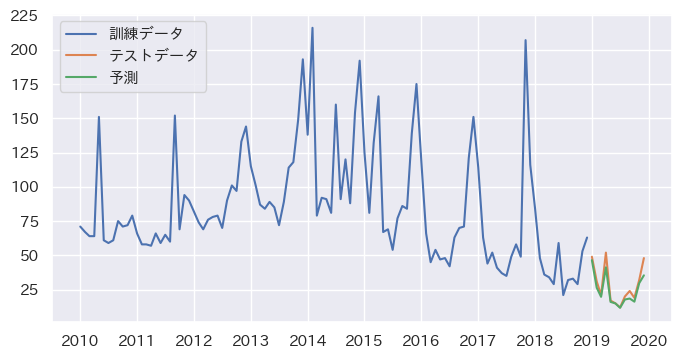

In [20]:
# =====================================================
# SARIMAX モデルによる予測と可視化
# =====================================================
# ・予測期間：12ヶ月先
# ・外生変数（exog）：テストデータの割引率
# ・予測値は対数変換を戻すため np.exp() で指数変換している
# =====================================================

# 12か月先を予測
pred_sarimax = mod_sarimax.forecast(12, exog=test["discount"].values.reshape(-1, 1))

# -----------------------------------------------------
# 可視化
# -----------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))

# 訓練データとテストデータを折れ線グラフで描画
ax.plot(train["sales"], label="訓練データ")
ax.plot(test["sales"], label="テストデータ")

# SARIMAXモデルによる予測値を指数変換して描画
ax.plot(np.exp(pred_sarimax), label="予測")

# 凡例の追加
ax.legend()

In [21]:
# =====================================================
# SARIMAXモデルによる予測区間（信頼区間）の計算
# =====================================================
# get_forecast() を使うことで、予測値とその信頼区間を同時に取得できる
# steps：予測期間（ここでは12ヶ月先）
# exog ：外生変数（ここではテストデータの割引率）
# alpha：信頼水準（0.05 → 95%信頼区間）
# =====================================================

pred_ci = mod_sarimax.get_forecast(
    steps=12, exog=test["discount"].values.reshape(-1, 1)
)

# 予測値・信頼区間を含むDataFrameを表示
print(pred_ci.summary_frame(alpha=0.05).head(3))

sales           mean   mean_se  mean_ci_lower  mean_ci_upper
2019-01-01  3.839753  0.105924       3.632145       4.047360
2019-02-01  3.273199  0.120689       3.036653       3.509744
2019-03-01  2.982691  0.140423       2.707466       3.257915


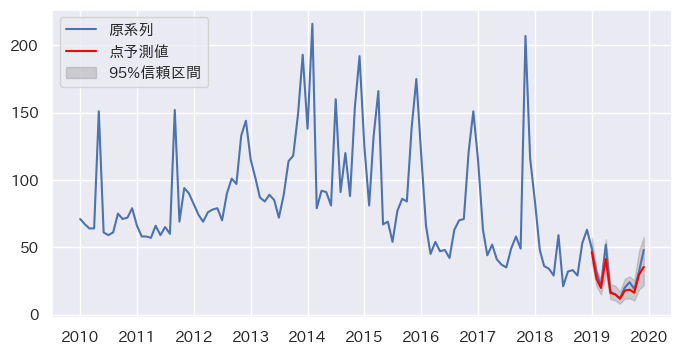

In [22]:
# =====================================================
# 対数変換していた予測値を指数変換して元のスケールに戻す
# =====================================================
conf_int_df_exp = pred_ci.summary_frame(alpha=0.05).apply(np.exp)

# -----------------------------------------------------
# グラフの作成（予測値と95%信頼区間の可視化）
# -----------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))

# 原系列（実データ）のプロット
ax.plot(ts_sales_bj["sales"], label="原系列")

# 点予測値（赤線）
ax.plot(conf_int_df_exp["mean"], color="red", label="点予測値")

# 信頼区間（灰色の帯）
ax.fill_between(
    test.index,  # 横軸にテストデータの時間
    conf_int_df_exp["mean_ci_lower"],  # 下限値
    conf_int_df_exp["mean_ci_upper"],  # 上限値
    alpha=0.3,  # 透過度
    color="gray",  # 色指定（灰色）
    label="95%信頼区間",
)

# 凡例の表示
ax.legend()